In [52]:
import random
import numpy as np 
import random
import matplotlib.pyplot as plt
import time


In [53]:
# Générer le graphe TSP incomplet
def generate_tsp_incomplete(num_sommets, max_poids_arete):
    matrice = [[None for _ in range(num_sommets)] for _ in range(num_sommets)]
    intervalles = {}
    for i in range(num_sommets):
        intervalle_start = random.randint(0, 10)
        intervalle_end = intervalle_start + random.randint(5, 100)
        intervalles[i] = (intervalle_start, intervalle_end)
    for i in range(num_sommets):
        for j in range(i + 1, num_sommets):
            if random.choice([True, False]):
                poids = random.randint(1, max_poids_arete)
                matrice[i][j] = poids
                matrice[j][i] = poids
    for i in range(num_sommets):
        pas_connexe = True
        for j in range(num_sommets):
            if matrice[i][j] is None:
                matrice[i][j] = float('inf')
            else:
                pas_connexe = False
        if pas_connexe:
            poids = random.randint(1, max_poids_arete)
            if i != (num_sommets-1):
                matrice[i][num_sommets-1] = poids
                matrice[num_sommets-1][i] = poids
            else:
                matrice[i][num_sommets-2] = poids
                matrice[num_sommets-2][i] = poids
    return np.array(matrice), intervalles

In [54]:
num_sommets = 5
max_poids_arete = 10

# Générer les données du problème
tsp_matrice, tsp_intervalles = generate_tsp_incomplete(num_sommets, max_poids_arete)

# Afficher la matrice pondérée
print("\nMatrice pondérée:")
for row in tsp_matrice:
    print(row)

# Afficher les intervalles
print("\nIntervalles des sommets")
print(tsp_intervalles)


Matrice pondérée:
[inf inf inf inf  8.]
[inf inf inf  1.  6.]
[inf inf inf  3.  1.]
[inf  1.  3. inf  5.]
[ 8.  6.  1.  5. inf]

Intervalles des sommets
{0: (6, 65), 1: (9, 42), 2: (9, 28), 3: (5, 24), 4: (3, 58)}


In [55]:
# Paramètres de la colonie de fourmis
num_ants = 10
num_iterations = 100
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
pheromone_constant = 100 

In [56]:
def is_edge_valid(from_node, to_node, current_length, visited):
    weight = tsp_matrice[from_node][to_node]
    if weight == np.inf:
        return (False, 0)
    if to_node in visited:
        min_weight, max_weight = tsp_intervalles[to_node]
        if current_length + weight > max_weight:
            return (False, 0)
        if current_length + weight < min_weight:
            return (True,  min_weight - current_length)
    return (True, weight)

In [57]:

def update_pheromones(best_path, best_path_length, pheromone_matrix):
    pheromone_matrix *= (1 - evaporation_rate)
    for i in range(len(best_path) - 1):
        from_node = best_path[i]
        to_node = best_path[i + 1]
        pheromone_matrix[from_node][to_node] += pheromone_constant / best_path_length

In [58]:
def select_next_node(current_node, visited, current_length, pheromone_matrix):
    probabilities = []
    total_prob = 0
    pheromone_row = pheromone_matrix[current_node]
    heuristic_row = (1.0 / tsp_matrice[current_node]) ** beta

    for node in range(num_sommets):
        if node != current_node:
            valide, poids = is_edge_valid(current_node, node, current_length, visited)
            if valide:
                pheromone_level = pheromone_row[node] ** alpha
                heuristic_level = heuristic_row[node]
                probability = pheromone_level * heuristic_level
                probabilities.append((node, probability))
                total_prob += probability

    if total_prob == 0:
        return (None, 0)

    threshold = random.uniform(0, total_prob)
    cumulative_prob = 0
    for node, probability in probabilities:
        cumulative_prob += probability
        if cumulative_prob >= threshold:
            valide, poids = is_edge_valid(current_node, node, current_length, visited)
            return (node, poids)
    return (None, 0)


In [59]:
# def ant_colony_optimization():
#     best_path = None
#     best_path_length = float('inf')

#     # Initialiser les niveaux de phéromones uniquement sur les arêtes
#     pheromone_matrix = np.ones((num_sommets, num_sommets))

#     for iteration in range(num_iterations):
#         all_paths = []
#         for ant in range(num_ants):
#             current_node = random.randint(0, num_sommets - 1)
#             path = [current_node]
#             visited = {current_node}
#             min_weight, max_weight = tsp_intervalles[current_node]
#             current_length = min_weight

#             # Construire un chemin
#             while len(visited) < num_sommets:
#                 next_node, weight_to_add = select_next_node(current_node, visited, current_length, pheromone_matrix)
#                 if next_node is None:
#                     break
#                 current_length += weight_to_add
#                 current_node = next_node
#                 path.append(current_node)
#                 visited.add(current_node)

#             # Vérifier si un cycle est formé
#             valid, weight = is_edge_valid(current_node, path[0], current_length, visited)
#             if len(visited) == num_sommets and valid:
#                 current_length += weight
#                 path.append(path[0])
#                 all_paths.append((path, current_length))
#                 if current_length < best_path_length:
#                     best_path_length = current_length
#                     best_path = path

#         # Mettre à jour les phéromones uniquement sur le meilleur chemin trouvé
#         if best_path:
#             update_pheromones(best_path, best_path_length, pheromone_matrix)

#     return best_path, best_path_length
def ant_colony_optimization():
    best_path = None
    best_path_length = float('inf')
    execution_times = []
    distances = []

    # Initialize pheromone levels only on the edges
    pheromone_matrix = np.ones((num_sommets, num_sommets))

    for iteration in range(num_iterations):
        start_time = time.time()
        all_paths = []
        for ant in range(num_ants):
            current_node = random.randint(0, num_sommets - 1)
            path = [current_node]
            visited = {current_node}
            min_weight, max_weight = tsp_intervalles[current_node]
            current_length = min_weight

            # Construct a path
            while len(visited) < num_sommets:
                next_node, weight_to_add = select_next_node(current_node, visited, current_length, pheromone_matrix)
                if next_node is None:
                    break
                current_length += weight_to_add
                current_node = next_node
                path.append(current_node)
                visited.add(current_node)

            # Check if a cycle is formed
            valid, weight = is_edge_valid(current_node, path[0], current_length, visited)
            if len(visited) == num_sommets and valid:
                current_length += weight
                path.append(path[0])
                all_paths.append((path, current_length))
                if current_length < best_path_length:
                    best_path_length = current_length
                    best_path = path

        # Update pheromones only on the best path found
        if best_path:
            update_pheromones(best_path, best_path_length, pheromone_matrix)

        end_time = time.time()
        execution_times.append(end_time - start_time)
        distances.append(best_path_length)

    return best_path, best_path_length, execution_times, distances 

In [60]:
def plot_route(path, points):
    plt.figure(figsize=(10, 5))
    plt.scatter(points[:, 0], points[:, 1], c='blue')
    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i + 1]
        plt.plot([points[from_node, 0], points[to_node, 0]], [points[from_node, 1], points[to_node, 1]], 'k-')
    plt.title('Best Route Found')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()  

In [61]:
def plot_performance(execution_times, distances):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Execution Time (s)', color=color)
    ax1.plot(execution_times, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Best Path Length', color=color)  
    ax2.plot(distances, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()   
    plt.title('Performance Over Iterations')
    plt.show()

Meilleur chemin trouvé : [4, 2, 4, 2, 4, 2, 4, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 4, 0, 4] avec une longueur de 44.00


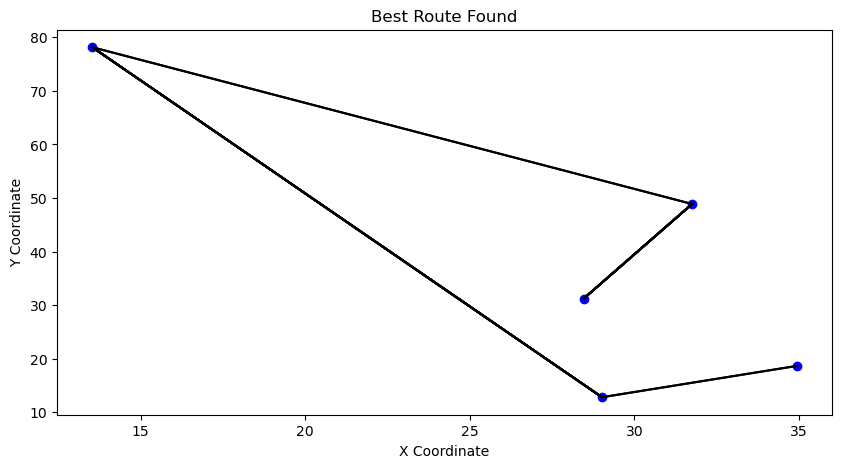

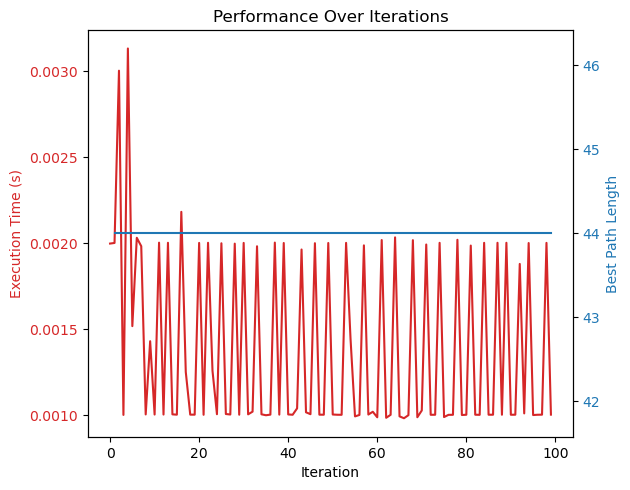

Best path length found: 44.00


In [62]:
best_path, best_path_length, execution_times, distances = ant_colony_optimization()

# Generate random points for plotting (for visualization purposes only)
points = np.random.rand(num_sommets, 2) * 100
print(f"Meilleur chemin trouvé : {best_path} avec une longueur de {best_path_length:.2f}")  
# Plot the best route
if best_path:
    plot_route(best_path, points)

# Plot the performance
plot_performance(execution_times, distances)

print(f'Best path length found: {best_path_length:.2f}') 